# Neural Style Transfer with tf.keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview
Este Notebook es una traducción de [este notebook](https://colab.research.google.com/github/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb#scrollTo=aDyGj8DmXCJI) hecha por Jorge Pérez Facuse
 
En este tutorial, aprenderemos como utilizar deep learning para crear imágenes con el estilo artístico de otra imagen (¿alguna vez quisiste poder pintar como Picasso o Van Gogh?). Esto es conocido como **neural style transfer** ! Esta es una técnica descrita en [el paper de Leon A. Gatys, A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576), la cual es una gran lectura que deberías chequear.

Pero, que es neural style transfer?

Neural style transfer es una técnica de optimizacion usada para tomar 3 imágenes: una de **contenido**, otra de **estilo** y la imagen de **input** que se quiere estilizar, y mezclarlas de tal forma que la imagen input es transformada en una imagen que luzca como la imagen de contenido, pero "pintada" en el estilo de la imagen de estilo.

Por ejemplo, tomemos una imagen de una tortuga y *The great Wave off Kanagawa* de Katsushika Hokusai:

<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/Green_Sea_Turtle_grazing_seagrass.jpg?raw=1" alt="Drawing" style="width: 200px;"/>
<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/The_Great_Wave_off_Kanagawa.jpg?raw=1" alt="Drawing" style="width: 200px;"/>

[Image of Green Sea Turtle](https://commons.wikimedia.org/wiki/File:Green_Sea_Turtle_grazing_seagrass.jpg)
-By P.Lindgren [CC BY-SA 3.0  (https://creativecommons.org/licenses/by-sa/3.0)], from Wikimedia Common


¿Como luciría la tortuga si Katsushika Hokusai hubiera decidido pintarla utilizando el estilo de *The great Wave*? Probablemente algo así:

<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/wave_turtle.png?raw=1" alt="Drawing" style="width: 500px;"/>

Es esto magia o simplemente deep learning? Afortunadamente, esto no involucra ninguna clase de brujería: Style Transfer es una entretenida e interesante técnica que demuestra las capacidades y representaciones internas de redes neuronales.

El principio de neural style transfer es definir 2 funciones de distancia, una que describa que tan diferente es el contenido de 2 imagenes, $L_{contenido}$, y otra que describa la diferencia de 2 imágenes en términos de su estilo, $L_{estilo}$. Entonces, dadas las 3 imágenes (estilo, contenido e input), tratamos de transformar la imagen input de tal forma que se minimice la distancia de contenido con la imagen de contenido y la distancia de estilo con la imagen de estilo.

En resumen, tomaremos la imagen base input, una imagen de contenido y otra de estilo, y transformaremos la imagen input minimizando las distancias de contenido y estilo(pérdidas) con backpropagation, creando una imagen que posea el contenido de la imagen de contenido y el estilo de la imagen de estilo.

### Conceptos específicos que serán cubiertos:

En el proceso, construiremos experiencia práctica y desarrollaremos intuicion alrededor de los siguientes conceptos

* **Eager Execution** - Usar el entorno imperativo de programación de Tensorflow que evaluar al instante
  * [Aprende más de eager execution](https://www.tensorflow.org/programmers_guide/eager)
  * [Míralo en acción](https://www.tensorflow.org/get_started/eager)
* **Utilizar [Functional API](https://keras.io/getting-started/functional-api-guide/) para definir un modelo** - construiremos un subset de nuestro modelo que nos dará acceso a las activaciones intermedias necesarias utilizando Functional API
* **Aprovechar los mapas de características(Feature Maps) de un modelo pre-entrenado** - Aprende como usar un modelo pre-entrenado y sus feature maps
* **Crear loops de entrenamiento personalizados** - Examinaremos como crear un optimizador para minimizar la pérdida con respecto a los parámetros del input

### Seguiremos los siguientes pasos generales para realizar el style transfer:

1. Visualizar la data
2. Preprocesamiento básico/preparar nuestra data
3. Preparar las funciones de pérdida
4. Crear el modelo
5. Optimizar para la función de pérdida

**Audiencia:** Este post esta pensado para usuarios intermedios que saben los conceptos básicos de machine learning. Para aprovechar al máximo este post, deberías: 
* Leer el [paper de Gatys](https://arxiv.org/abs/1508.06576) - lo explicaremos en el camino, pero de cualquier forma será beneficioso para entender de manera más general
* [Entender reducción de pérdida utilizando descenso de gradiente](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent)

**Tiempo estimado**: 30+ min


## Preparacion

### Descargar las imágenes

In [3]:
# Simplemente descargamos las imágenes que deseamos utilizar. Utilizamos la librería requests para descargar las imágenes
# sin problemas, independiente de nuestro sistema operativo. Las guardaremos simplemente en el directorio actual
# Para este ejemplo, utilizaremos imagenes provienentes del Museo Nacional de Bellas Artes de Chile.
import os
import requests
url_imagen_estilo = "http://www.surdoc.cl/sites/default/files/record_images/000000151617-original.jpg"
url_imagen_contenido = "http://www.surdoc.cl/sites/default/files/record_images/000000108790-original.jpg"
nombre_estilo, nombre_contenido = "estilo.jpg" , "contenido.jpg"
estilo = requests.get(url_imagen_estilo).content
contenido = requests.get(url_imagen_contenido).content
with open(nombre_estilo, "wb") as handler:
    handler.write(estilo)
with open(nombre_contenido, "wb") as handler:
    handler.write(contenido)

### Importar y configurar los modelos

In [1]:
#Importamos lo necesario de matplotlib para poder plotear las imágenes
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

#Importamos herramientas necesarias como numpy y otros
import numpy as np
from PIL import Image
import time
import functools

In [2]:
#Importamos todo lo necesario de tensorflow
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

Comenzaremos habilitando [eager execution](https://www.tensorflow.org/guide/eager). E Eager execution nos permite trabajar esta técnica de la forma más clara y legible posible

In [3]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [4]:
# Preparamos algunos valores globales aquí
content_path = 'melgas de oro.jpg'
style_path = 'flores.jpg'

## Visualizar el input

In [5]:
#Esta funcion nos permite cargar la imagen dado el path
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img) 
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS) #Se cambia la escala de la imagen
  
  img = kp_image.img_to_array(img) #Convierte la imagen a un array de NumPy
  
  # Debemos crear el array de tal forma que posea batch dimension
  img = np.expand_dims(img, axis=0)
  return img

In [6]:
#Muestra una img
def imshow(img, title=None):
  # Remueve la batch dimension
  out = np.squeeze(img, axis=0)
  # Normaliza para mostrar
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

Estos son el input de imágenes de contenido y estilo. Esperamos "crear" una imagen con el contenido de nuestra imagen de contenido, pero con el estilo de la imagen de estilo

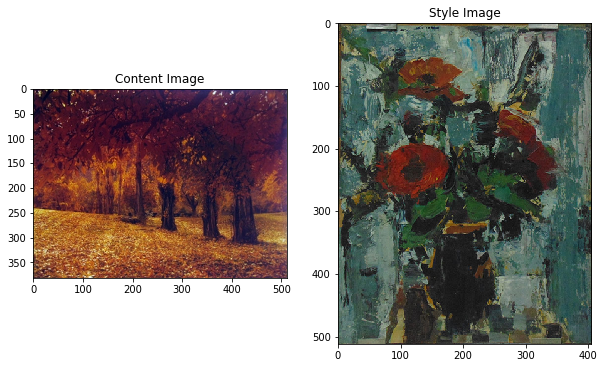

In [7]:
plt.figure(figsize=(10,10))
#Cargamos las imagenes
content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

#Probamos plotear las 2 imagenes para asegurarnos de que todo este funcionando
plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

## Preparar la data
Creemos métodos que nos permitan cargar y preprocesar nuestrar imagenes fácilmente. Realizamos el mismo proceso de preprocesamiento que es esperado de acuerdo al proceso de entrenamiento VGG. Las redes VGG son entrenadas en imagen con cada canal normalizado por `mean = [103.939, 116.779, 123.68]` y con canales BGR

In [8]:
#Funcion que sirve para cargar y preprocesar la imagen dado un path. Se utiliza el preprocesamiento de VGG19 que viene
#incluido en keras
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img


Para poder ver os outputs de nuestra optimización, es necesario realizar el paso inverso del preprocesamiento. Además, dado que nuestra imagen optimizada puede tomar valores en cualquier parte entre $- \infty$ y $\infty$, debemos clipearlo para mantener nuestros valores en el rango de 0-255.

In [9]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input debe ser una imagen de"
                             "dimension [1, height, width, channel] o [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Input no válido para deprocesar imagen")
  
  # Se realiza el preprocesamiento inverso. Puede parecer que esto aparece de la nada, pero es simplemente hacer lo contrario
  # a lo que hace el preprocesamiento de vgg19
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  #Aquí se "clipean" los valores de manera que queden entre 0 y 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

### Definir representaciones de contenido y estilo
Para poder obtener tanto las representaciones de contenido como de estilo de nuestra imagen, veremos algunas capas(layers) intermedias en nuestro modelo. Al ir más profundo en el modelo, estas layers intermedias representan características(features) de cada vez más alto orden. En este caso, estamos utilizando la arquitectura de red VGG19, una red de clasificación de imágenes preentrenada. Estas capas intermedias son necesarias para definir la representación del contenido y del estilo de nuestras imágenes. Para una imagen input, trataremos de asimilar la representación correspondiente de estilo y contenido objetivo en estas capas intermedias.

#### ¿Porque capas intermedias?

Podrías estarte preguntando porque estos outputs intermedios en nuestra red de clasificación de imágenes preentrenada nos permiten definir representaciones de estilo y contenido. A alto nivel, este fenómeno puede ser explicado por el hecho de que para que una red realice clasificasión de imágenes(para lo cual nuestra red a sido entrenada), debe comprender la imagen. Esto involucra tomar la imagen como pixeles y construir una representación interna mediante trasformaciones que transforman la imagen original en una compleja comprensión de las *features* presentes en la imagen. Esto es además parte de porque las redes neurales convolucionales son capaces de generalizar bien: son capaces de capturar las invarianzas y definir *features* entre clases (ej. perros v/s gatos) que son indiferentes al ruido de fondo y otras molestias. Así, en alguna parte entre donde la imagen original es provista y el label de clasificación del output, este modelo sirve como un extractor de *features* complejas; entonces accediendo a layers intermedias, somos capaces de describir el contenido y estilo de imágenes input.

Específicamente, vamos a extraer las siguientes layers intermedias de nuestra red:


In [10]:
#Estas layers son simplemente unas pertenecientes al modelos vgg19, que podemos obtener con sus nombres(puestos a continuacion)

# Layer de contenido de donde extraremos nuestros mapas de características
content_layers = ['block5_conv2'] 

# Layers de estilo en las que estamos interesados:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Construir el modelo
En este caso, cargamos [VGG19](https://keras.io/applications/#vgg19), y lo ponemos como input tensor en el modelo. Esto nos permitira extraer los mapas de características (y por lo tanto las representaciones de estilo y contenido) de la imagen de estilo, contenido e input.

Utilizamos VGG19, como lo sugiere el paper. Además, como VGG19 es un modelo relativamente simple(comparado con ResNet, Inception, etc), los mapas de características trabajan mejor de hecho para *style transfer*


Para poder acceder a las layers intermedias que corresponden a nuestros mapas de características de contenido y estilo, obtenemos los outputs correspondientes (las layers definidas anteriormente), y utilizando [**Functional API**](https://keras.io/getting-started/functional-api-guide/) de Keras definimos nuestro modelo con los outputs deseados.
Definir un modelo con Fuctional API simplemente involucra poner el input y el output del modelo: 

`model = Model(inputs, outputs)`

In [11]:
def get_model():
  """ Crea nuestro modelo con acceso a las layers intermedias. 
  
  Esta funcion va a cargar el modelo VGG19 y accederá a las capas intermedias.
  Estas layers serán utilizadas para crear un nuevo modelo que tomará la imagen input
  y retornara los outputs de las capas intermedias del modelo VGG
  
  Retorna:
    retorna un modelo keras que toma inputs de imagenes y retorna las
    layers intermedias de estilo y contenido
  """
  # Cargamos nuestro modelo. Cargamos VGG preentrenado, entrenado en data de imagenet
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  # Como no lo vamos a entrenar, ponemos trainable como False
  vgg.trainable = False
  # Obtenemos las layers de estilo y contenido correspondientes. Simplemente con get_layer(name) se puede obtener esto
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Costruir el modelo
  return models.Model(vgg.input, model_outputs)


En el código de arriba, cargaremos nuestra red de clasificación de imágenes preentrenada. Luego tomamos las layers de interés como lo definimos anteriormente. Después definimos un modelo seteando el input del modelo a una imagen y el output como las layers intermedias de contenido y estilo!


## Definir y crear nuestras funciones de pérdidas (distancias de estilo y contenido)

### Pérdida de contenido

Nuestra definición de pérdida de contenido es de hecho bastante simple. Pasaremos a la red tanto la imagen de contenido deseada como nuestra imagen base de input. Esto retornará las layers intermedias de output (de las layers definidas arriba) de nuestro modelo. Entonces simplemente tomaremos la distancia euclidiana entre las dos representaciones intermedias de esas imagenes.


Más formalmente, nuestra pérdida de contenido es una función que describe la distancia de contenido de nuestra imagen output $x$ y nuestra imagen de contenido $p$. Sea $C_{nn}$ una red neuronal convolucional preentrenada. De nuevo, en este caso utilizamos [VGG19](https://keras.io/applications/#vgg19). Sea $X$ cualquier imagen, entonces $C_{nn}(X)$ es la red alimentada por $X$. Sea $F^l_{ij}(x) \in C_{nn}(x)$ y $P^l_{ij}(p) \in C_{nn}(p)$ los cuales describen sus respectivas características intermedias de la red con los inputs $x$ y $p$ en la capa $l$. Entonces describimos la distancia de contenido (pérdida) como :$$L^l_{content}(p, x) = \sum_{i, j} (F^l_{ij}(x) - P^l_{ij}(p))^2$$

Realizamos backpropagation de la manera habitual tal que minimizamos esta pérdida de contenido. Luego, cambiamos la imagen inicial hasta que genere una respuesta similar en una determinada capa (definida en content_layer) como la imagen original de contenido

Esto puede ser implementado fácilmente. De nuevo tomaremos como input los mapas de características en la capa L en una red alimentada por x, nuestra imagen input, y p, nuestra imagen de contenido, y retornaremos la distancia de contenido



### Calcular la pérdida de contenido
Vamos a sumar nuestras pérdidas de contenido en cada una de las capas deseadas. De esta forma, cuando alimentemos nuestro modelo con la imagen input, en cada iteración todas las pérdidas de contenido se van a calcular apropiadamente y como estamos usando Eager Execution, todos los gradientes van a ser calculados

In [12]:
def get_content_loss(base_content, target):
  # Aqui simplemente se utilizan funciones matemáticas de tensorflow para replicar la fórmula descrita arriba
  # tf.square eleva al cuadrado un tensor (la unidad básica de tensorflow) y reduce_mean va sumando los promedios de 
  # los tensors, calculando así la perdida de contenido
  return tf.reduce_mean(tf.square(base_content - target))

## Pérdida de estilo

Calcular la pérdida de estilo es un poco más complicado, pero sigue el mismo principio, sólo que esta vez alimentando a nuestra red con la imagen input y la imagen de estilo. Sin embargo, en vez de comparar directamente los outputs intermedios de la imagen input y la imagen de estilo, comparamos las Gram matrices de los 2 outputs.

Matemáticamente, describimos la pérdida de estilo entre la imagen input $x$, y la imagen estilo, $a$, como la distancia entre la representación de estilo (las gram matrices) de estas imagenes. Describimos la representación de estilo de una imagen como la correlación entre distintas respuestas a filtros dados por la Gram matrix $G^l$, donde $G^l_{ij}$ es el producto interno entre el mapa de características vectorizado $i$ e $j$ en la capa $l$. Podemos ver que $G^l_{ij}$ generado sobre el mapa de características para una imagen dada representa la correlación entre los mapas de características $i$ e $j$

Para generar un estilo para nuestra imagen input base, realizamos descenso de gradientes desde la imagen de contenido para transformarla en una imagen que asimile la representacion de estilo de la imagen original. Esto lo hacemos minimizando la media de la distancia al cuadrado entre el mapa de correlaciones de características de la imagen estilo y la imagen input. La contribución de cada capa a la pérdida total de estilo esta descrita por
$$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j}(G^l_{ij} - A^l_{ij})^2$$

donde $G^l_{ij}$ y $A^l_{ij}$ son las respectivas representaciones de estilo en la capa $l$ de $x$ y $a$. $N_l$ describe el número de mapas de características, cada uno de tamaño $M_l = ancho * alto$. Entonces, la pérdida total de estilo a través de cada capa es 
$$L_{style}(a, x) = \sum_{l \in L} w_l E_l$$
donde pesamos la contribución de capa capa por un factor $w_l$. En nuestro caso, pesamos cada capa igualmente ($w_l =\frac{1}{|L|}$)

### Calcular la pérdida de estilo
De nuevo, implementamos la pérdida de estilo como una métrica de distancia. 

In [26]:
def gram_matrix(input_tensor):
  # Se hace los canales de imagen primero. Recordar que la imagen tiene una forma (h, w, c) , donde c son los canales
  channels = int(input_tensor.shape[-1]) #Se obtiene la forma del tensor y se selecciona la cantidad de canales
    
  # tf.reshape cambia la forma del tensor. -1 hace que reshape asuma la cantidad de (en este caso) filas del tensor
  # tal que se ajuste con la cantidad 'channels' de columnas. Así, se logra una matriz n x m la cual posee todas las
  # entradas del tensor original pero en 2 dimensiones en vez de 3
  a = tf.reshape(input_tensor, [-1, channels])

  # n va a ser la cantidad de filas que poseera "a", es decir, el número que simboliza el -1 de arriba
  n = tf.shape(a)[0]

  #Tal como es definida una gram matrix de un conjunto de vectores v1..vn, corresponde en cada entrada de la matriz i,j al resultado
  # del producto interno vi * vj. Esto se puede hacer fácilmente como una multiplicación de matrices, en donde se traspone la
  # primera para que, al realizar la multiplicacion, se obtenga efectivamente la gram matrix. 
  gram = tf.matmul(a, a, transpose_a=True)
  return gram# / tf.cast(n, tf.float32) #Queda pendiente revisar la validez del tf.cast

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filtros de cada capa
  # Escalamos la pérdida en una capa dada por el tamaño del mapa de características y el número de filtros
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style) #base_style (que es una imagen) se convierte a gram matrix
  
  return tf.reduce_mean(tf.square(gram_style - gram_target)) / (4. * (channels ** 2) * (width * height) ** 2) #Esto estaba comentado originalmente

## Aplicar Style transfer a nuestras imágenes


### Correr descenso de gradientes
Si no estás familiarizado con descenso de gradientes/backpropagation o necesitas un refresco de memoria, deberías chequear esta [increíble recurso](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent).

En este caso, utilizamos el optimizador [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)* para minimizar nuestra pérdida. Iterativamente actualizamos nuestra imagen output de tal forma que minimice la pérdida: No actualizamos los pesos asociados a nuestra red, sino que entrenamos nuestra imagen input para minimizar la pérdida. Para poder hacer esto, debemos saber como calcular nuestra pérdida y gradientes.

\* Notar que L-BFGS, el cual si estas familiarizado con este algoritmo es recomendado, no se utiliza en este tutorial debido a que la motivación principal de este tutorial era ilustrar las mejores prácticas con eager execution, y, utilizando Adam, podemos demostrar la funcionalidad de autogradiente/cinta gradiente con un loop personalizado de entrenamiento



Definiremos una pequeña funcion auxiliar que cargará nuestra imagen de contenido y estilo, y las alimentará a traves de nuestra red, la cual va a entregar las representaciones de características de contenido y estilo.

In [14]:
def get_feature_representations(model, content_path, style_path):
  """Funcion auxiliar para calcular nuestras representaciones de estilo y contenido

  Esta función simplemente cargará y preprocesará tanto la imagen de estilo
  como de contenido desde su path. Luego las alimentará a través de la red para
  obtener los outputs de las capas intermedias
  
  Argumentos:
    model: El modelo que estamos usando.
    content_path: El path a la imagen de contenido.
    style_path: El path a la imagen de estilo
    
  Retorna:
    Retorna las características de estilo y contenido.
  """
  # Carga nuestras imagenes con las funciones definidas anteriormente
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # Calcula en lote las representaciones de estilo y contenido
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Obtiene las representaciones de características de estilo y contenido.
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

### Calcular la pérdida y las gradientes
Aquí utilizamos [**tf.GradientTape**](https://www.tensorflow.org/programmers_guide/eager#computing_gradients) para calcular la gradiente. Nos permite tomar ventaja de la diferenciación automática disponible rastreando operaciones para calcular el gradiente después. Esto graba las operaciones durante el pase hacia adelante y luego es capaz de calcular el gradiente de nuestra función de pérdida con respecto a nuestra imagen input para el pase hacia atrás.

Entonces, para sintetizar, GradientTape graba las operaciones que se hagan dentro de su context manager (su 'with') y luego, utilizando el método gradient de GradientTape, es capaz de calcular la gradiente de dichas operaciones. Esto lo hace utilizando [diferenciación automática](https://en.wikipedia.org/wiki/Automatic_differentiation).

In [15]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """Esta función va a calcular la pérdida total.
  
  Argumentos:
    model: El modelo que nos dará acceso a las capas intermedias 
    loss_weights: Los pesos de cada contribución de cada función de pérdida.
      (peso de estilo, peso de contenido, y peso de variación total)
    init_image: Nuestra imagen base inicial. Esta imagen es la cual estamos
      actualizando con nuestro proceso de optimización. Aplicamos los gradientes
      con respecto a la pérdida que estamos calculando a esta imagen.
    gram_style_features: Gram matrices precalculadas correspondientes a
      las capas de estilo definidas de interés.
    content_features: Outputs precalculados de las capas de contenido de 
      interés.
      
  Retorna:
    retorna la pérdida total, pérdida de estilo, pérdida de contenido, y variación
    total de pérdida
  """
  style_weight, content_weight = loss_weights
  
  # Alimenta nuestra imagen inicial a través del modelo. Esto nos dará las
  # representaciones de estilo y contenido en las capas deseadas. Como estamos
  # utilizando eager execution, nuestro modelo se puede llamar como cualquier
  # otra función !!!
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Acumula las pérdidas de estilo de todas las capas
  # Aquí, pesamos igualmente cada contribución de las capas de pérdida
  # Ojo que, si quisieramos que ciertas características del estilo 
  # fuesen más relevantes, bastaría con pesan de forma diferenciada
  # las distintas capas
  weight_per_style_layer = 1.0 / float(num_style_layers) #Peso igual para todas
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style) 
    
  # Acumula las pérdidas de contenido de todas las capas
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  # Se ponderan los scores obtenidos por el peso que le demos al contenido y al estilo
  style_score *= style_weight
  content_score *= content_weight

  # Se obtiene la pérdida total y se retorna esta junto con la pérdida de estilo y contenido
  loss = style_score + content_score 
  return loss, style_score, content_score

Calcular los gradientes es fácil:

In [16]:
def compute_grads(cfg):
  """
  Notar que cfg es un contenedor que posee todos los atributos necesarios 
  para utilizar compute_loss (definido arriba). Luego de utilizar
  compute_loss, extrae la pérdida total  y de ahí obtiene la 
  gradiente de la pérdida total con respecto a la imagen input
  utilizando tape.gradient
  """
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Calcula los gradientes con respecto a la imagen input
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

### Loop de optimización

In [28]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e2): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  # No necesitamos (o queremos) entrenar ninguna de las capas de nuestro modelo
  # asi que seteamos tu trainable a False
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Obtiene las representaciones de estilo y contenido (desde las capas intermedias especificadas)
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Setea la imagen inicial
  init_image = load_and_process_img(content_path)
  init_image = tfe.Variable(init_image, dtype=tf.float32)
  # Crea nuestro optimizador. En este caso, un Adam con los parámetros especificados aqui abajo
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # Para mostrar imágenes intermedias
  iter_count = 1
  
  # Guarda nuestro mejor resultado
  best_loss, best_img = float('inf'), None
  
  # creamos el cfg que se le pasa a compute_loss
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # Para mostrar. Se define el intervalo de display
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  # Se define el rango
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  
  # Aquí comienza el loop para optimizar. Cada vez que ocurre un ciclo
  # calcular primero las pérdidas y las gradientes. Luego, utiliza
  # el optimizador Adam y aplica las gradientes a la imagen inicial
  # y lo clippea dentro de el rango definido arriba.
  # Luego, si la nueva pérdida es menor que la mínima pérdida hasta el momento
  # la guarda como la menor pérdida. Además, actualiza el display si el 
  # numero de iteracion es divisible por display_interval
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Utiliza el metodo .numpy() para obtener el array de numpy concreto
      # Lo que se hace a continuación no es más que preparar el display de las imagenes
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    
  # Al terminar el loop, muestra todas las imagenes que se guardaron en los intervalos establecidos
  # Finalmente, retorna la mejor imagen y la mejor pérdida
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

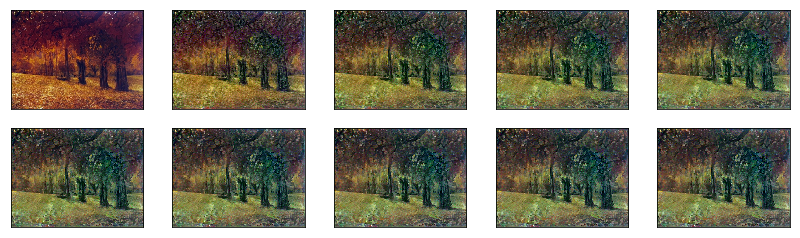

In [29]:
#Ahora, ya esta terminado el Style transfer, y se puede correr de la siguiente forma:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

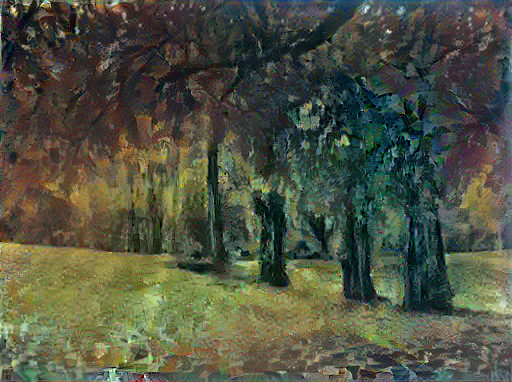

In [31]:

Image.fromarray(best)

## Visualizar los outputs
Deprocesamos la imagen output.

In [19]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

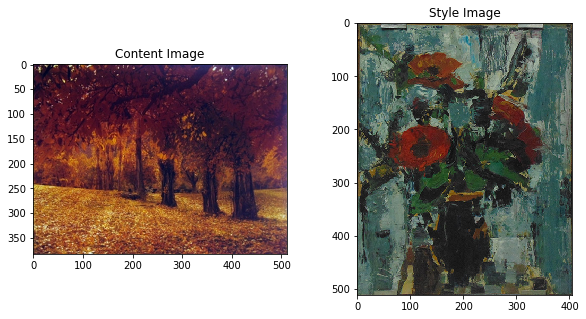

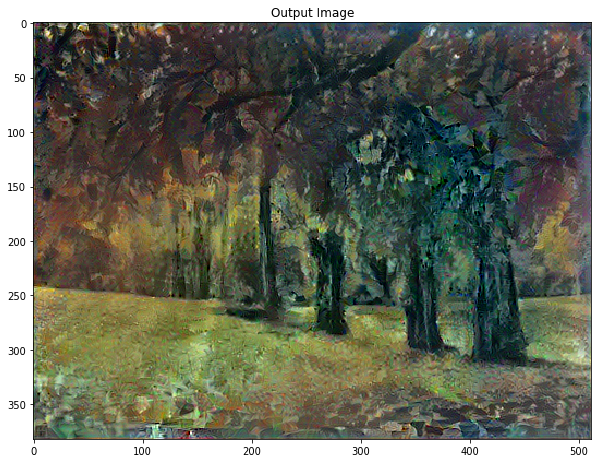

In [32]:
show_results(best, content_path, style_path)

## Prueba otras imágenes
Puedes ingresar a [este sitio](http://niebla.ing.puc.cl/surdoc/index.html) para buscar imágenes del Museo de Bellas Artes y así probar el style transfer en distintas imágenes!

## Adquisiciones clave

### Que cubrimos:

* Construimos varias funciones diferentes de pérdida y utilizamos backpropagation para transformar nuestra imagen input para minimizar estas pérdidas
  * Para hacer esto tuvimos que cargar un **modelo preentrenado** y utilizar sus mapas de características aprendidos para describir las representaciones de estilo y contenido de nuestras imágenes
    * Nuestras funciones de pérdida estaban principalmente calculando la distancia en terminos de estas distintas representaciones
* We implemented this with a custom model and **eager execution**
* Implementamos esto con un modelo personalizado y **eager execution**
  * Construimos nuestro modelo personalizado con la Functional API
  * Eager execution nos permite trabajar dinámicamente con tensors, utilizando un control de flujo natural de python
  * Manipulamos los tensores directamente, lo que hace debuggear y trabajar con tensores más fácil
* Iterativamente actualizamos nuestra imagen aplicandole nuestras reglas de optimización de actualizacion utilizando **tf.gradient**. El optimizador minimizaba una pérdida dada con respecto a nuestra imagen input.


**[Image of Green Sea Turtle](https://commons.wikimedia.org/wiki/File:Green_Sea_Turtle_grazing_seagrass.jpg)**
By P.Lindgren [CC BY-SA 3.0 (https://creativecommons.org/licenses/by-sa/3.0)], from Wikimedia Commons

